# PDE-Refiner {#sec-toc}

PDE-Refiner: Achieving Accurate Long Rollouts with Neural PDE Solvers
(https://arxiv.org/abs/2308.05732) [@lippe2023pderefiner]

## Paper Summary {#sec-overview}

- PDE-Refiner is a method for improving the accuracy of neural PDE solvers over long time horizons.
- The key insight that led to the method was a spectrum analysis showing a neglect of the low amplitude frequencies
- Their solution introduces iterative refinement through denoising at each step where in varying the standard deviation of the noise the model can learn to denoise across varying amplitude levels.

## Presentation Outline

- This presentation will first introduce deep learning based methods for solving PDEs along with an understanding of the 1D Kuramoto Sivashinsky PDE. 

- Then we will see how numerical methods are used to solve the 1D-KS equation in generating training data for PDE-Refiner and what the training process looks like. 

- Then we will reproduce the papers results that the PDE-Refiner method produces longer, more stable rollouts compared to a similar network without this additinoal refinement.

- Finally we will discuss potential research directions along with any results from initial experiments or work in these directions

# Understanding

## Understanding Deep Learning Neural Surrogates for PDEs

Deep learning as universal function approximators, DeepONet paper on universal approximation theorems applied to learning operators

Curve fitting of single PDE to operator learning, data fitting across multiple boundary conditions and parameters.

High levels bullets pros / convs vs. very well developed traditional numerical methods

## Understanding the 1D Kuramoto-Sivashinsky PDE

Modeling laminar flame fronts, other physical concrete examples.

$$
u_t + uu_x + u_{xx} + \nu u_{xxxx} = 0
$$ {#eq-1dks}

- PDE
- 4th order
- nonlinear
- chaotic

---

> The nonlinear term $uu_x$ and the fourth-order derivative $u_{xxxx}$ make the PDE a challenging objective for traditional solvers.

- $u(x, t)$ is scalar valued
- $\nu$ viscosity, $\nu = 1$
- $uu_x$ nonlinear spacial derivative representing convective effects or self-interaction
- $u_{xx}$ diffusive or dissipative effects
- $u_{xxxx}$ higher-order dispersion or stabilizing term

> the main dynamics of the KS equation are modeled within a frequency band of
low wavenumbers (1 to 25) As a result, the primary errors in predicting a one-step solution arise from inaccuracies in modeling the dynamics of these low frequencies.

# Solving 1D-KS

## Solving 1D-KS To Generate Training Data

1. Pseudospectral for spatial derivatives
2. Radau for time stepping

Why these methods?

- High fidelity of results for pseudo-spectral needed for training data with fidelity across frequency spectrum
- Stiff, commonly reached for solvers insufficient. 

Notes on stability, consistency, convergence, etc. 

---

Brandstetter. Lie Point Symmetry Data Augmentation for Neural PDE Solvers. (https://arxiv.org/abs/2202.07643)

https://github.com/brandstetter-johannes/LPSDA#produce-datasets-for-kuramotoshivashinsky-ks-equation

Fourer series represent function as sum of sinusoidal functions  

Coefficients sampled   
$A_m$ amplitude   
$\ell_m$ wavenumber  
$\phi_m$ phase shift  
$L$ length of the spatial domain

$$
\begin{align*}
L \sim U(0.9 \cdot 64, 1.1 \cdot 64) \\
\Delta{t} \sim U(0.18, 0.22) \\
u_0(x) = \sum_{1}^{m=10}{A_m \sin(2\pi \ell_m x/L + \phi_m)}
\end{align*}
$$

---

- First 360 truncated as warmup for solver
- Generated float64 then stored as float32 for training ("convert the precision in spacial domain" ?, wavenumber higher than 60 cannot be represented)
- 2048 trajectories in train with duration / rollout length of $140\Delta{t}$
- 128 trajectories in test with duration / rollout length of $640\Delta{t}$

---

Not all code will or need be shown.

In [1]:
#| output: false
#| code-line-numbers: "|1-5|7-8|10-15"
import numpy as np
import math
from scipy.integrate import solve_ivp
from scipy.fftpack import diff as psdiff
import matplotlib.pyplot as plt

def initial_condition(x):
    return np.cos(x / 16) * (1 + np.sin(x / 16))

def pseudospectral_reconstruction(t: float, u: np.ndarray, L: float) -> np.ndarray:
    ux = psdiff(u, 1, L)
    uxx = psdiff(u, 2, L)
    uxxxx = psdiff(u, 4, L)
    dudt = -u * ux - uxx - uxxxx
    return dudt

ModuleNotFoundError: No module named 'scipy'

In [198]:
L = 64
N = 256
x = np.linspace(0, L, N, endpoint=False)
dx = x[1] - x[0]

In [199]:
u0 = initial_condition(x)

In [200]:
t_span = (0, 140)
dt = 0.2
t_steps = math.ceil(t_span[1] / dt)
t_eval = np.linspace(t_span[0], t_span[1], t_steps)

---

In [201]:
%%time
sol = solve_ivp(
    pseudospectral_reconstruction,
    t_span, 
    u0, 
    args=(L,), 
    t_eval=t_eval, 
    method='BDF',
)

CPU times: user 7.5 s, sys: 250 ms, total: 7.75 s
Wall time: 889 ms


Adjust visualiations for presentation, hide plotting code

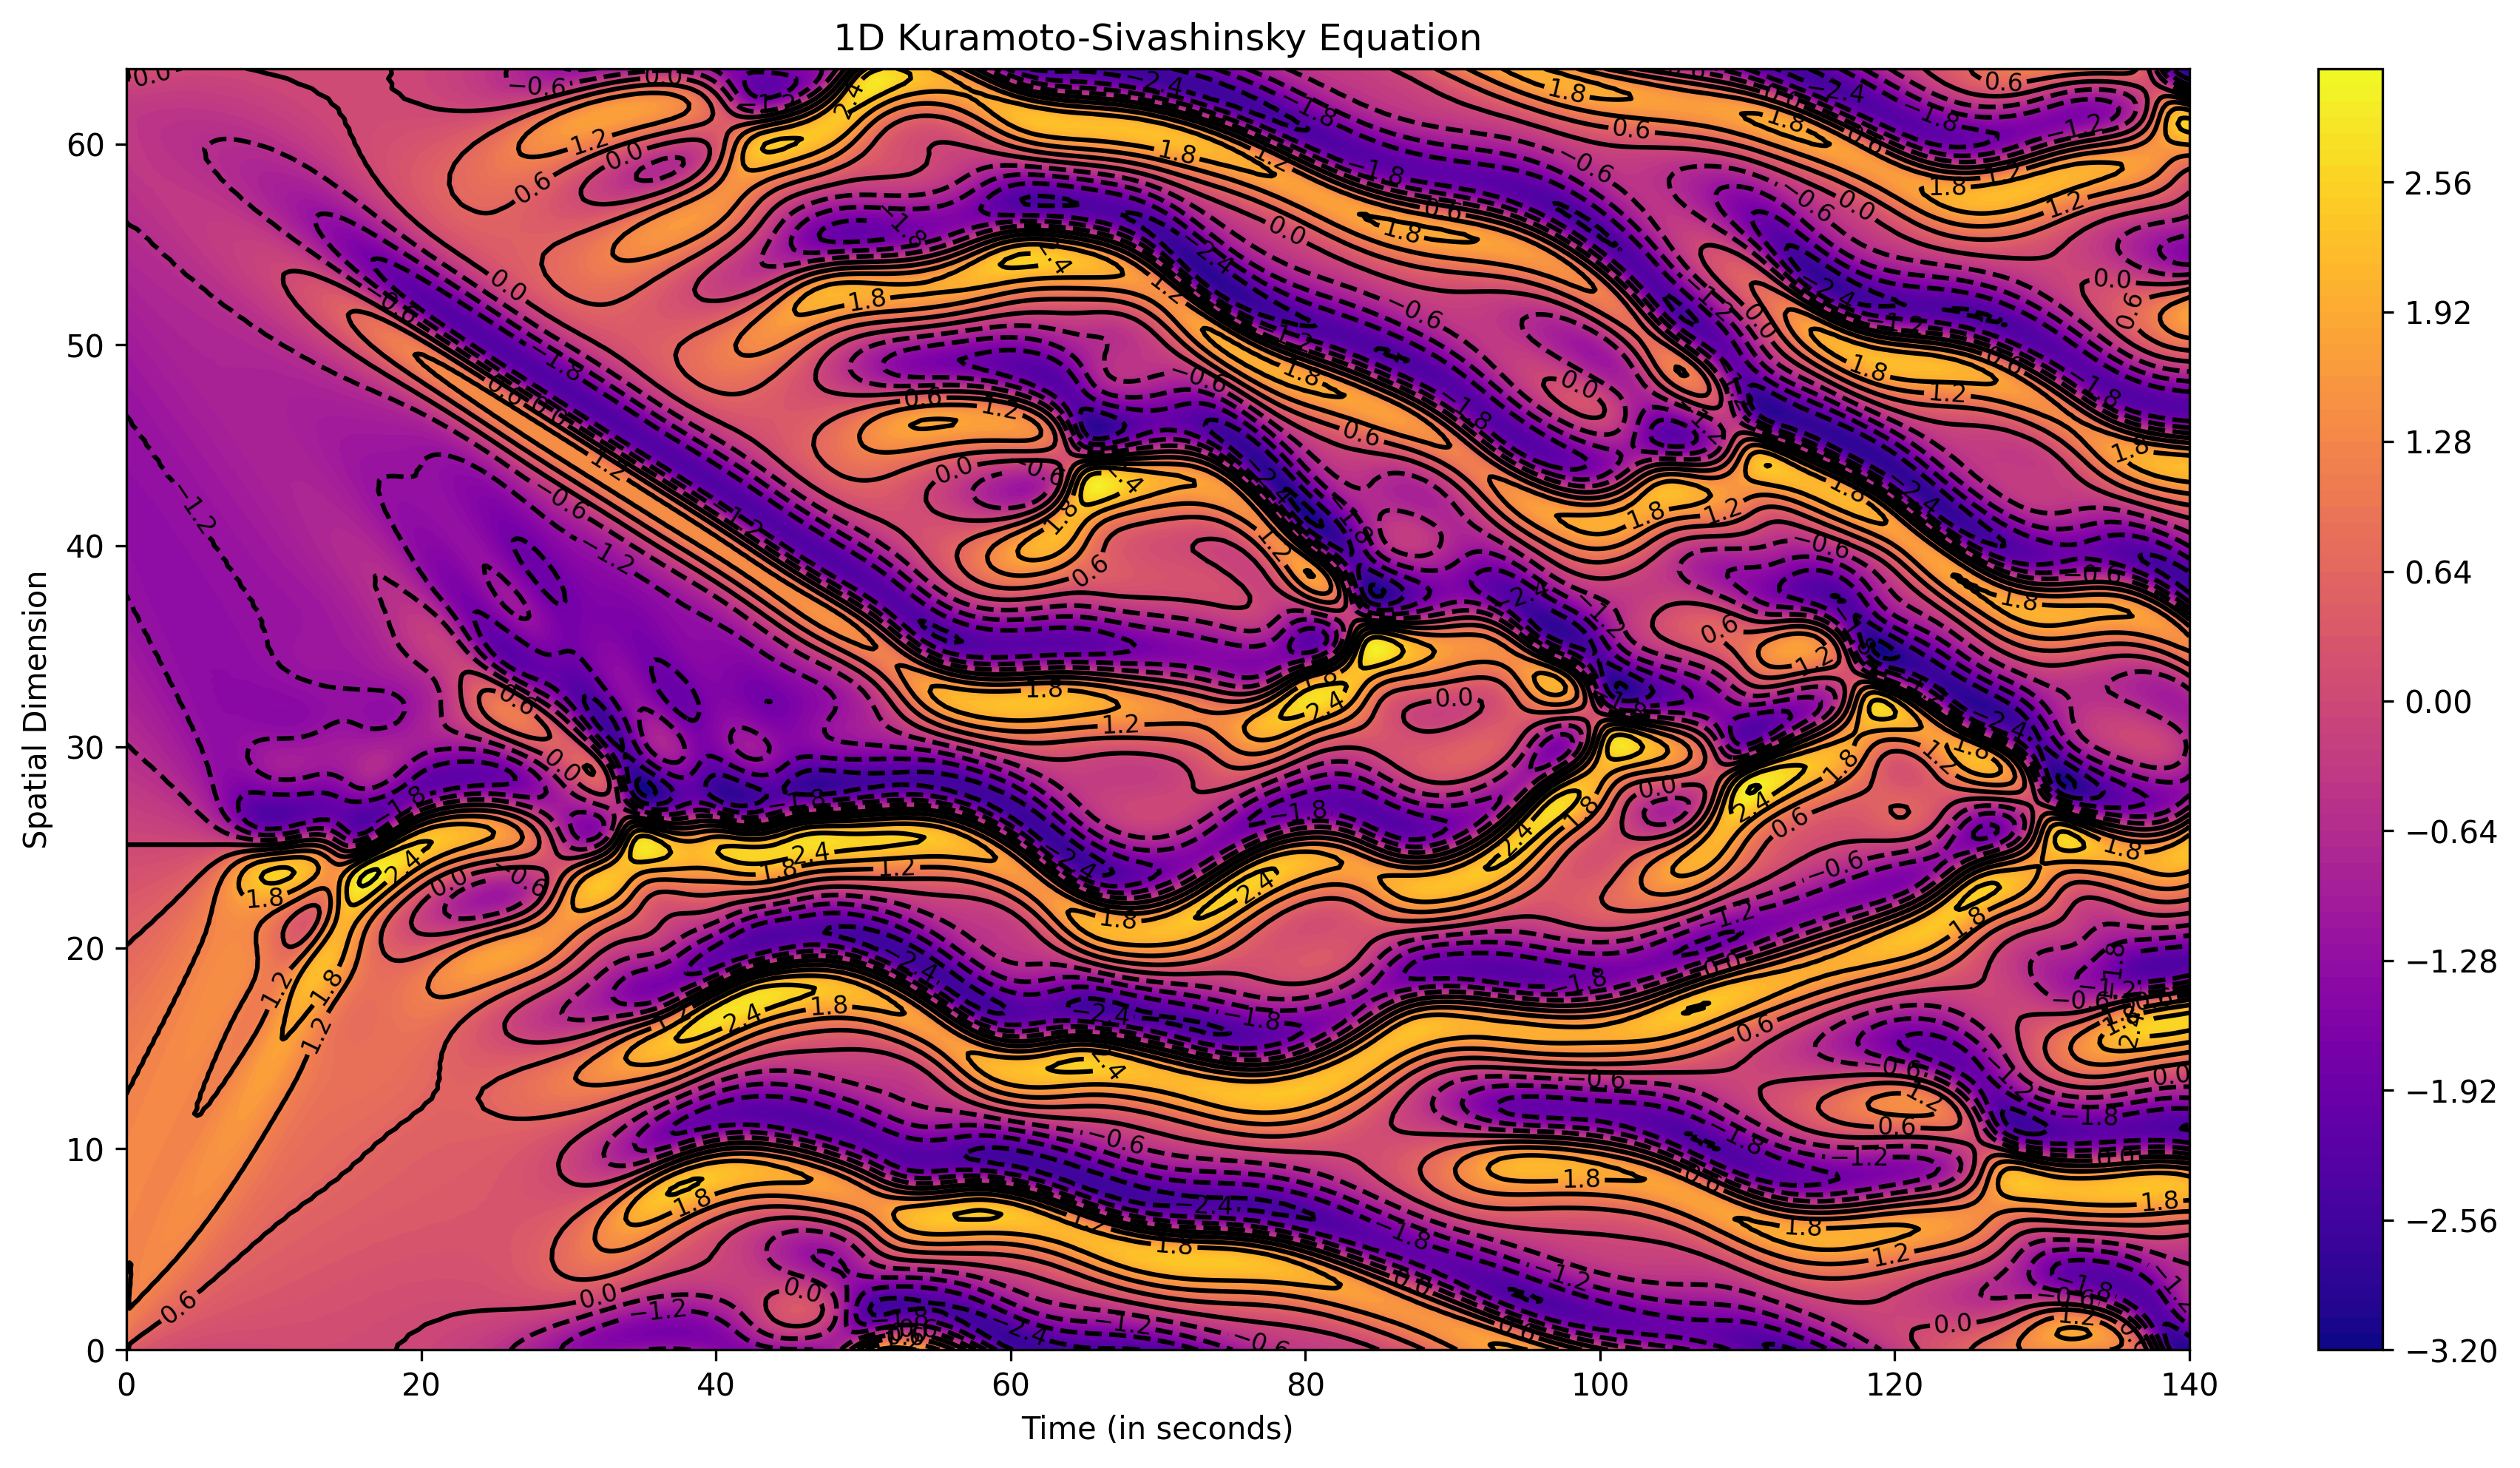

In [212]:
T, X = np.meshgrid(t_eval, x)
plt.figure(figsize=(15, 7.5), dpi=300)
contourf = plt.contourf(T, X, sol.y, 100, cmap='plasma')
plt.colorbar(contourf)
contours = plt.contour(T, X, sol.y, 10, colors='black')
plt.clabel(contours, inline=True, fontsize=8)
plt.title('1D Kuramoto-Sivashinsky Equation')
plt.xlabel('Time (in seconds)')
plt.ylabel('Spatial Dimension')
plt.show()

# Training Neural Surrogate

# Models and Training

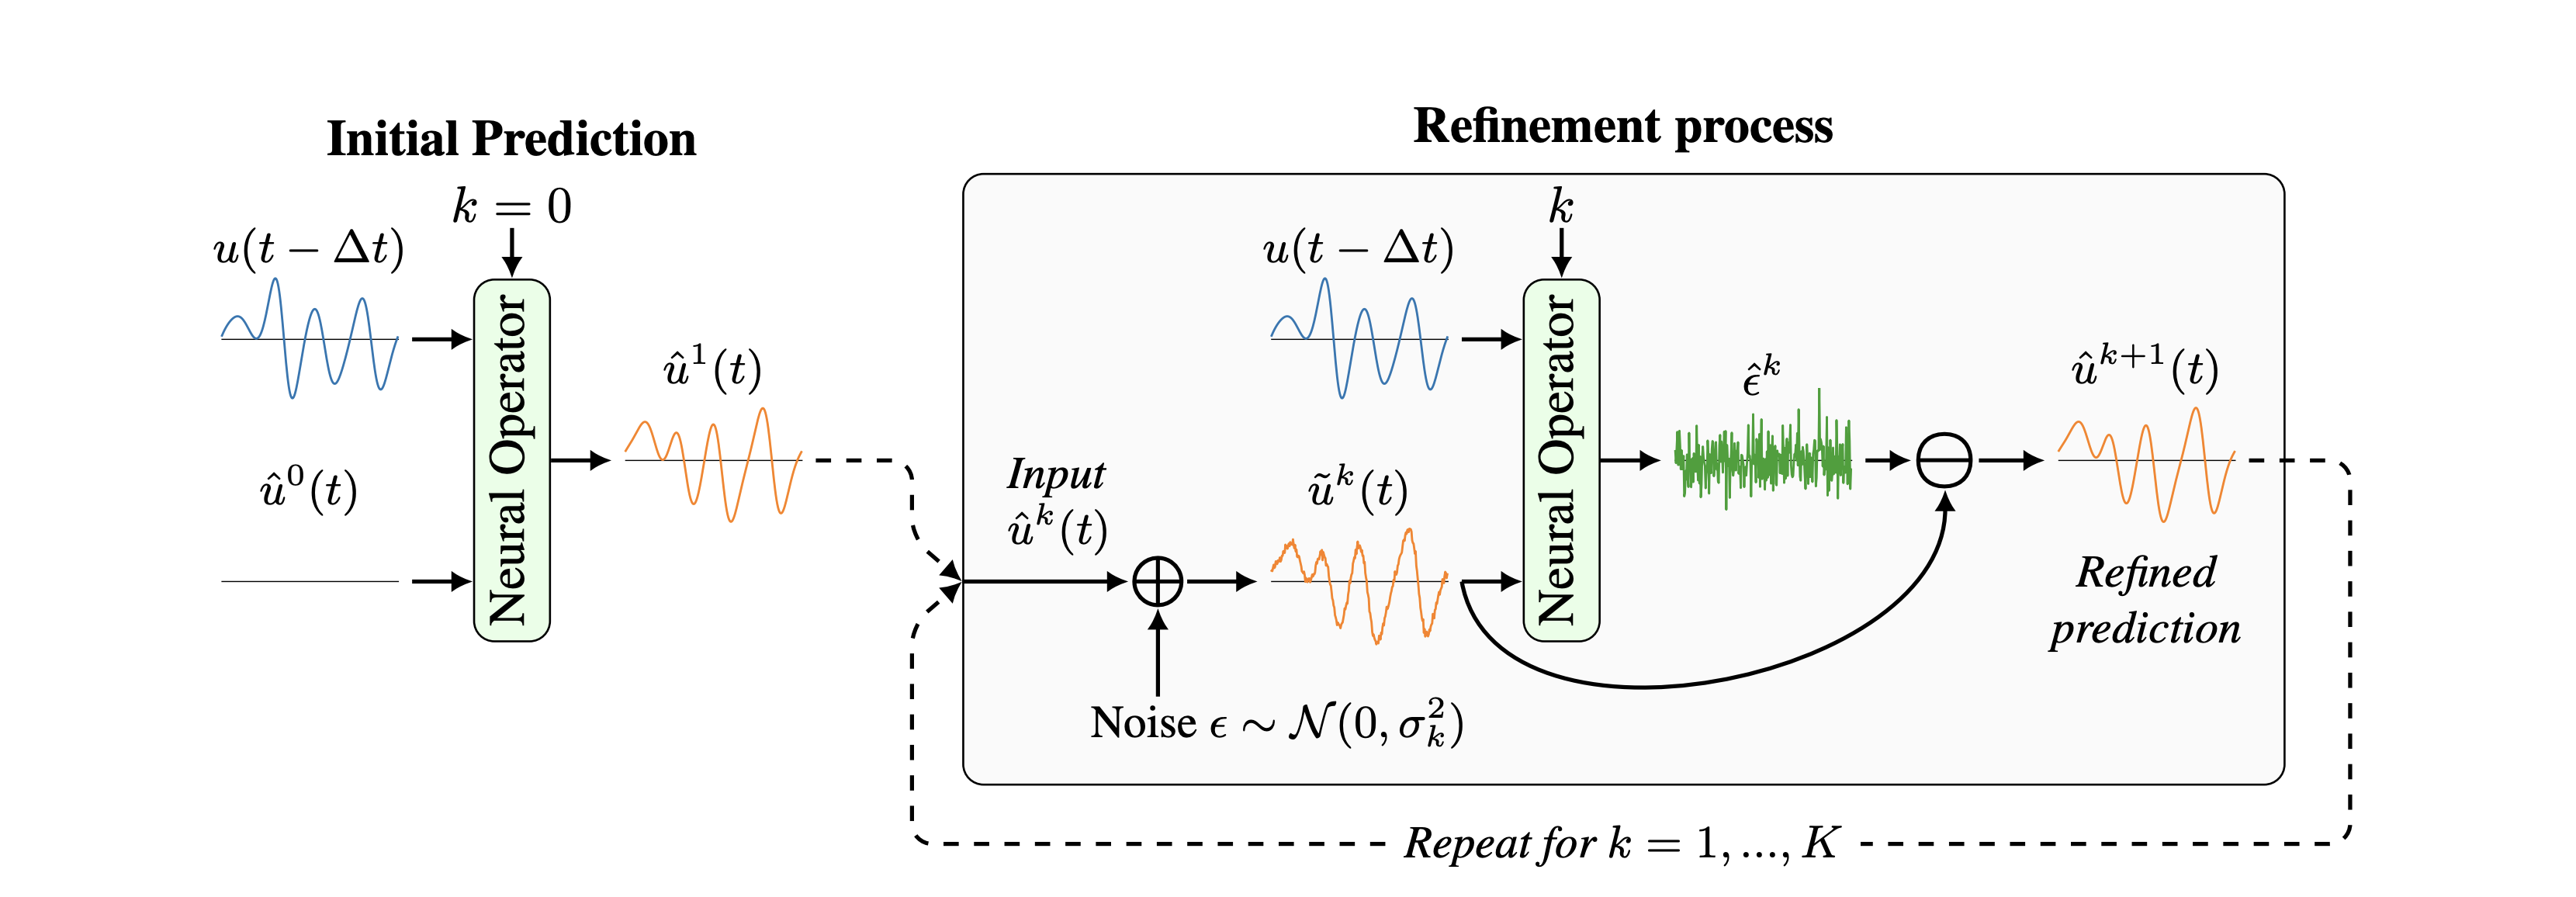

$$
\begin{align*}
\text{Solve for all } x \text{ and } t \text{ on a domain } [0, L] \\
\text{Periodic boundary conditions } u(0, t) = u(L, t) \\
\text{Initial condition } u(x, 0) = u_0(x) \\
\text{Discretized input space } N_x \text{ and } N_t \\
\text{Trained neural operator } \texttt{NO} \\
\text{Time step } \Delta{t} \\
\text{Model } \hat{u}(t) = \mathtt{NO}(u(t - \Delta{t})) \\
\text{Rollout } \hat{u}(t + \Delta{t}) = \mathtt{NO}(\hat{u}(t)) \\
\text{One step MSE loss, learn PDE dynamics } \mathcal{L_{\mathrm{MSE}}} = || u(t) - \mathtt{NO}(u(t - \Delta{t})) ||^{2} \\
\end{align*}
$$

- Input $u(t - 4\Delta{t})$, $L$, $\Delta{t}$
- Output $u(t)$ $4\Delta{t}$ in future
- Predicts residual $\Delta{u}(t) = u(t) - u(t - 4\Delta{t})$ instead of $u(t)$ directly
- $\hat{u}(t) = u(t - 4\Delta{t}) + 0.3 \cdot \mathtt{NO} (u(t - 4\Delta{t}))$

---

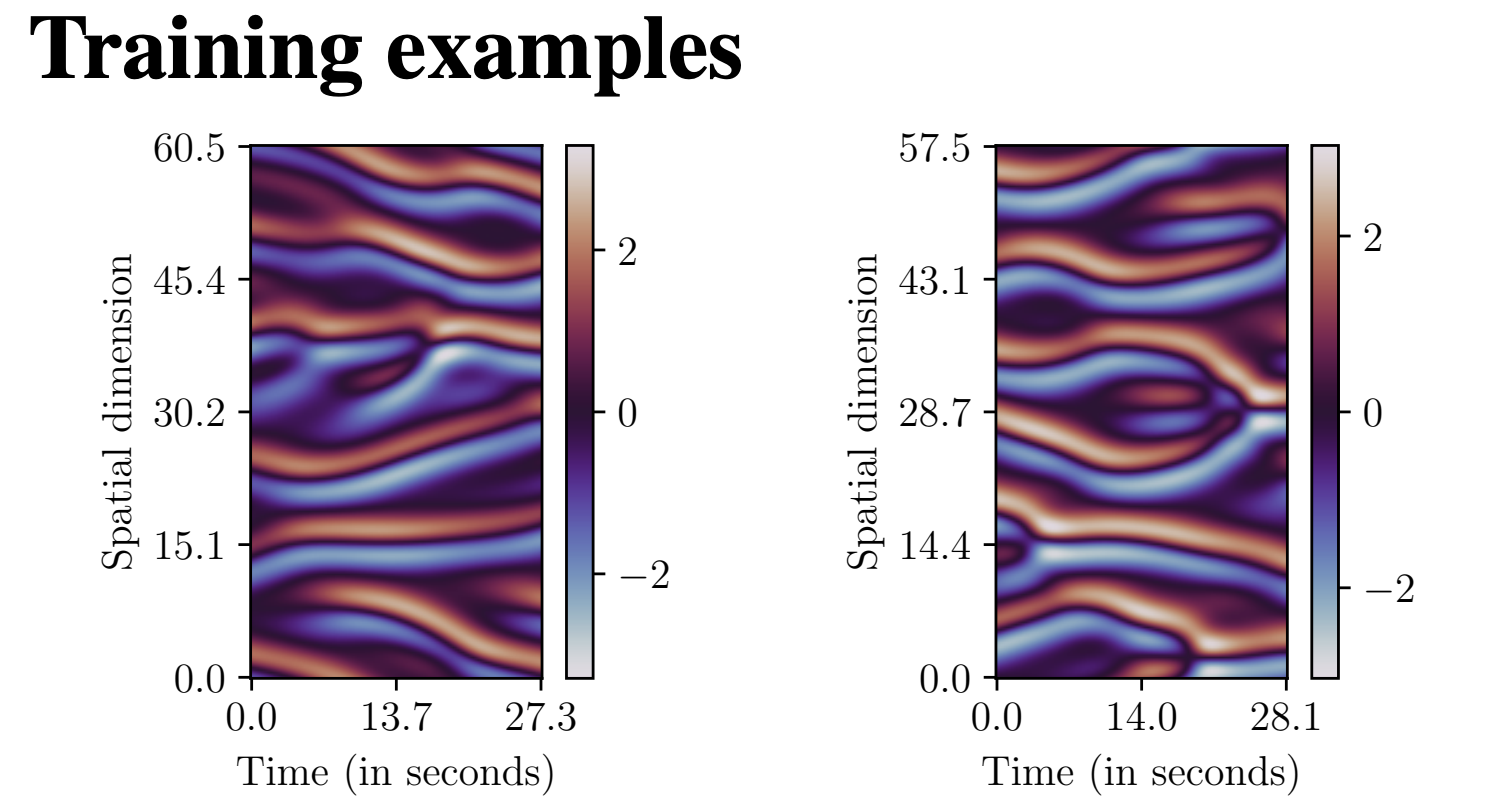

---

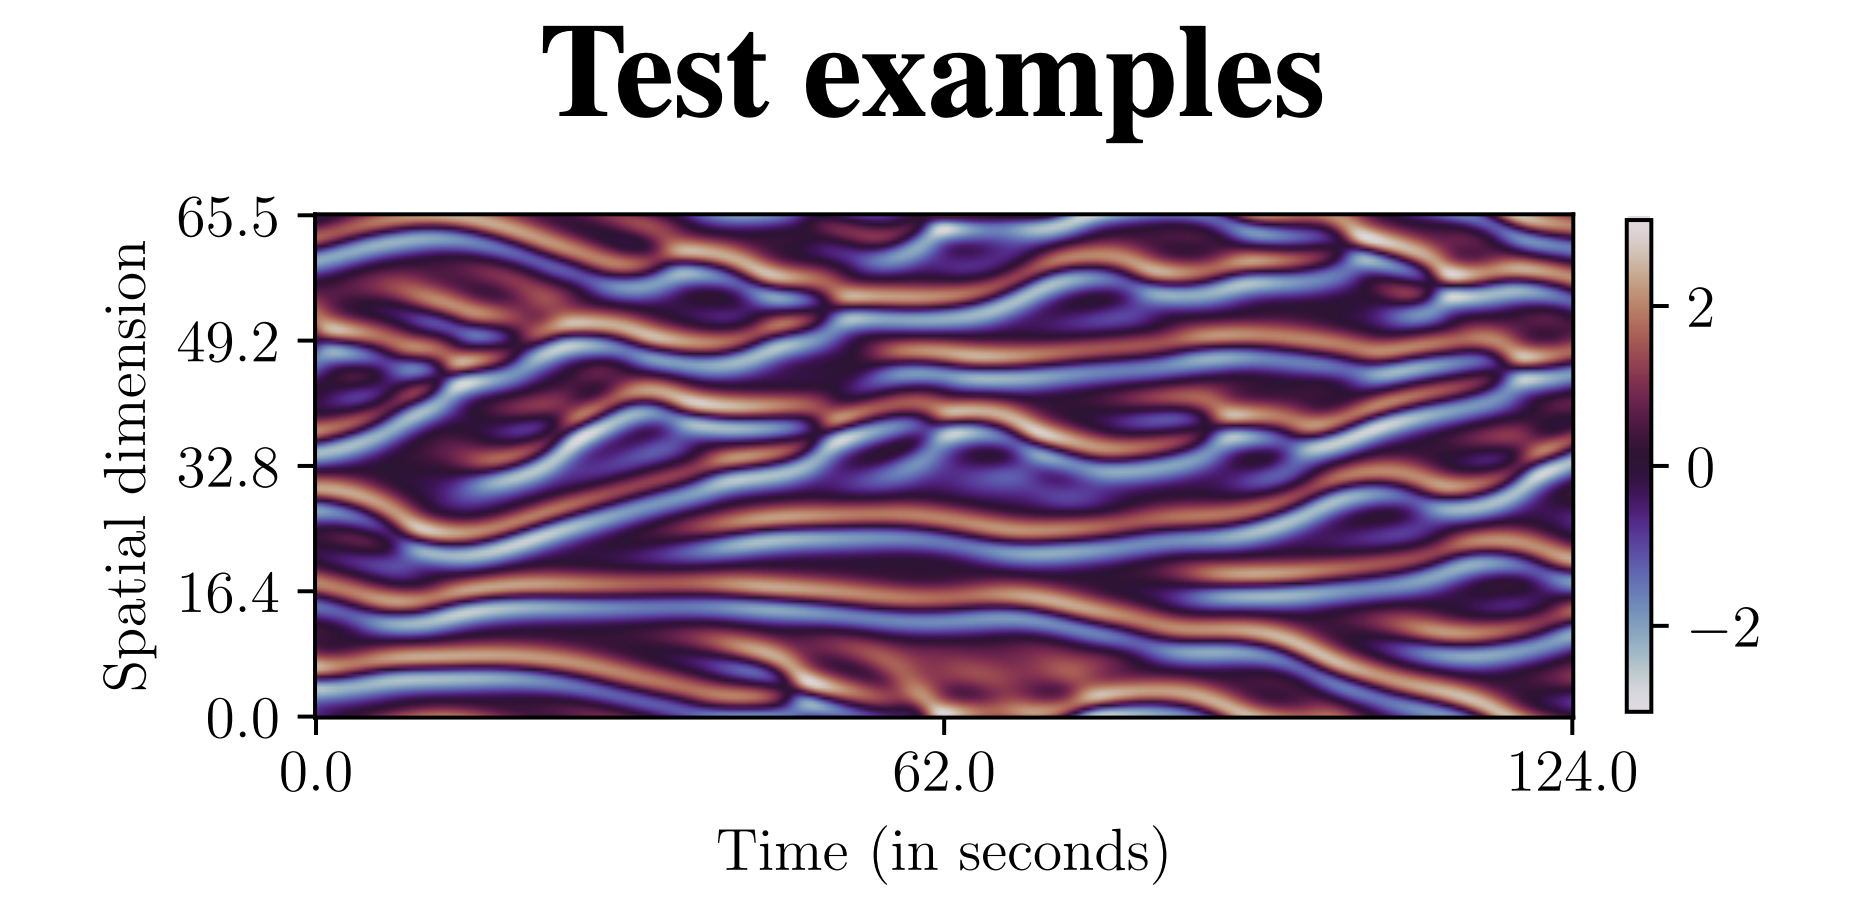

# Experimental Results

# Research Directions

# Appendix

# PSDIFF

In [ ]:
Want to work on getting this down to very understanble mapping between mathematics and the code. Probably not needed in presentation.

In [7]:
import numpy as np

def psdiff(u, n, L):
    """
    Compute the n-th derivative of a periodic function u(x) using the pseudo-spectral method.
    
    Parameters:
    - u: numpy array, the values of the function u(x) on a uniform grid of the domain.
    - n: int, the order of the derivative to compute.
    - L: float, the length of the domain over which u is defined.
    
    Returns:
    - dudx_n: numpy array, the n-th derivative of u.
    """
    N = len(u) # Number of grid points
    k = 2 * np.pi / L * np.fft.fftfreq(N) # Wavenumbers: fftfreq accounts for even and odd N
    
    # Compute the FFT of the input function
    u_hat = np.fft.fft(u)
    
    # Multiply by (ik)^n to compute the n-th derivative in the spectral domain
    dudx_n_hat = (1j * k)**n * u_hat
    
    # Inverse FFT to transform back to the physical domain
    dudx_n = np.fft.ifft(dudx_n_hat).real # Take the real part to avoid numerical artifacts
    return dudx_n


In [69]:
def df(x):
    dx = 0.01
    df = (np.sin(x + dx) - np.sin(x)) / dx
    return df

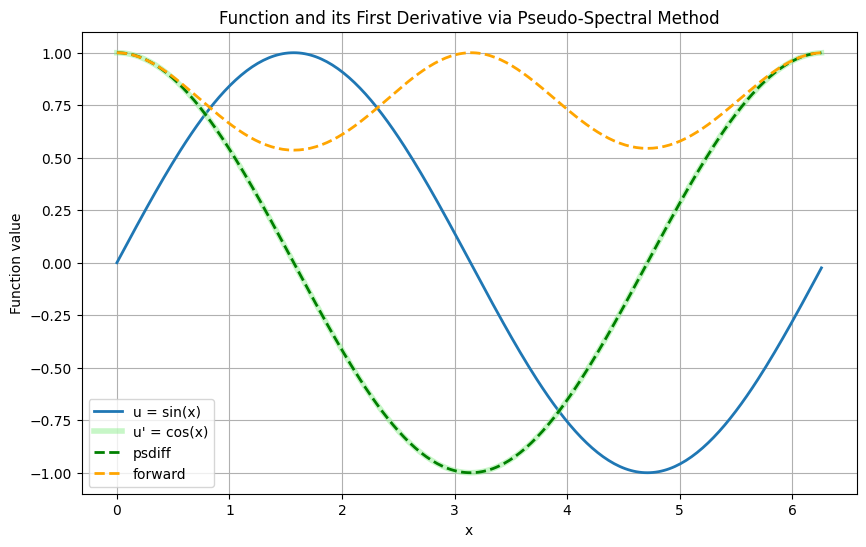

In [70]:
import numpy as np
import matplotlib.pyplot as plt

def compute_derivative(u, dx):
    N = len(u)
    k = np.fft.fftfreq(N, d=dx) * 2 * np.pi  # Correct k scaling
    u_hat = np.fft.fft(u)
    du_dx_hat = 1j * k * u_hat
    du_dx = np.fft.ifft(du_dx_hat).real
    return du_dx

L = 2 * np.pi
N = 256
dx = L / N
x = np.linspace(0, L - dx, N)
# TODO: Simple period function that could be reprented compositely not a single wave
u = np.sin(x)
u_prime_analytical = np.cos(x)
du_dx = compute_derivative(u, dx)
du_dx2 = df(u)

plt.figure(figsize=(10, 6))
plt.plot(x, u, label='u = sin(x)', linewidth=2)
plt.plot(x, u_prime_analytical, label="u' = cos(x)", linestyle='-', linewidth=4, color='lightgreen', alpha=0.5)
plt.plot(x, du_dx, label='psdiff', linestyle='--', linewidth=2, color='green')
plt.plot(x, du_dx2, label='forward', linestyle='--', linewidth=2, color='orange')
plt.legend()
plt.xlabel('x')
plt.ylabel('Function value')
plt.title('Function and its First Derivative via Pseudo-Spectral Method')
plt.grid(True)
plt.show()


# References